In [118]:
!pip install pandas numpy matplotlib seaborn networkx


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [120]:
df = pd.read_csv('lol_ranked_games.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  killedElderDrake         242572 non-null  int64  
 14  lost

In [121]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
df.tail(10)

Total rows: 242572
Total columns: 59


,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
242562,4402156483,1774000,0,20,1440,1464,0.4,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,23,17,37,48,11,11
242563,4402156483,1774000,0,22,1291,634,0.2,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,25,20,41,54,11,12
242564,4402156483,1774000,0,24,-1321,-2549,-0.4,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,29,28,45,57,12,12
242565,4402156483,1774000,0,26,-4062,-5239,-0.8,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,30,32,47,67,14,15
242566,4402156483,1774000,0,28,-5640,-9016,-1.0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,33,36,50,74,15,16
242567,4402156483,1774000,0,30,-8523,-13498,-1.6,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,1,0,0,1,1,33,41,50,80,18,17
242568,4379826739,1013000,0,10,-271,-1243,-0.2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,6,18,1,2
242569,4379826739,1013000,0,12,-2013,-3493,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,8,6,23,1,5
242570,4379826739,1013000,0,14,-2388,-4543,-0.8,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,13,9,27,5,6
242571,4379826739,1013000,0,16,-5601,-7595,-1.2,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,17,10,31,6,10


In [122]:
print("Missing Data: \n", df.isnull().sum())

Missing Data: 
 gameId                     0
gameDuration               0
hasWon                     0
frame                      0
goldDiff                   0
expDiff                    0
champLevelDiff             0
isFirstTower               0
isFirstBlood               0
killedFireDrake            0
killedWaterDrake           0
killedAirDrake             0
killedEarthDrake           0
killedElderDrake           0
lostFireDrake              0
lostWaterDrake             0
lostAirDrake               0
lostEarthDrake             0
lostElderDrake             0
killedBaronNashor          0
lostBaronNashor            0
killedRiftHerald           0
lostRiftHerald             0
destroyedTopInhibitor      0
destroyedMidInhibitor      0
destroyedBotInhibitor      0
lostTopInhibitor           0
lostMidInhibitor           0
lostBotInhibitor           0
destroyedTopNexusTurret    0
destroyedMidNexusTurret    0
destroyedBotNexusTurret    0
lostTopNexusTurret         0
lostMidNexusTurret         

In [123]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.describe(include='all'))

             gameId  gameDuration         hasWon          frame  \
count  2.425720e+05  2.425720e+05  242572.000000  242572.000000   
mean   4.501480e+09  1.785494e+06       0.498128      19.811264   
std    5.331693e+07  3.761901e+05       0.499998       7.197339   
min    4.357970e+09  5.490000e+05       0.000000      10.000000   
25%    4.463051e+09  1.532000e+06       0.000000      14.000000   
50%    4.529395e+09  1.774000e+06       0.000000      18.000000   
75%    4.543718e+09  2.025000e+06       1.000000      24.000000   
max    4.547671e+09  3.428000e+06       1.000000      56.000000   

            goldDiff        expDiff  champLevelDiff   isFirstTower  \
count  242572.000000  242572.000000   242572.000000  242572.000000   
mean      -11.413811    -215.019351       -0.026517       0.617709   
std      5438.051920    5261.880802        0.772366       0.485948   
min    -21578.000000  -32484.000000       -4.000000       0.000000   
25%     -3420.250000   -3148.000000       -0.6

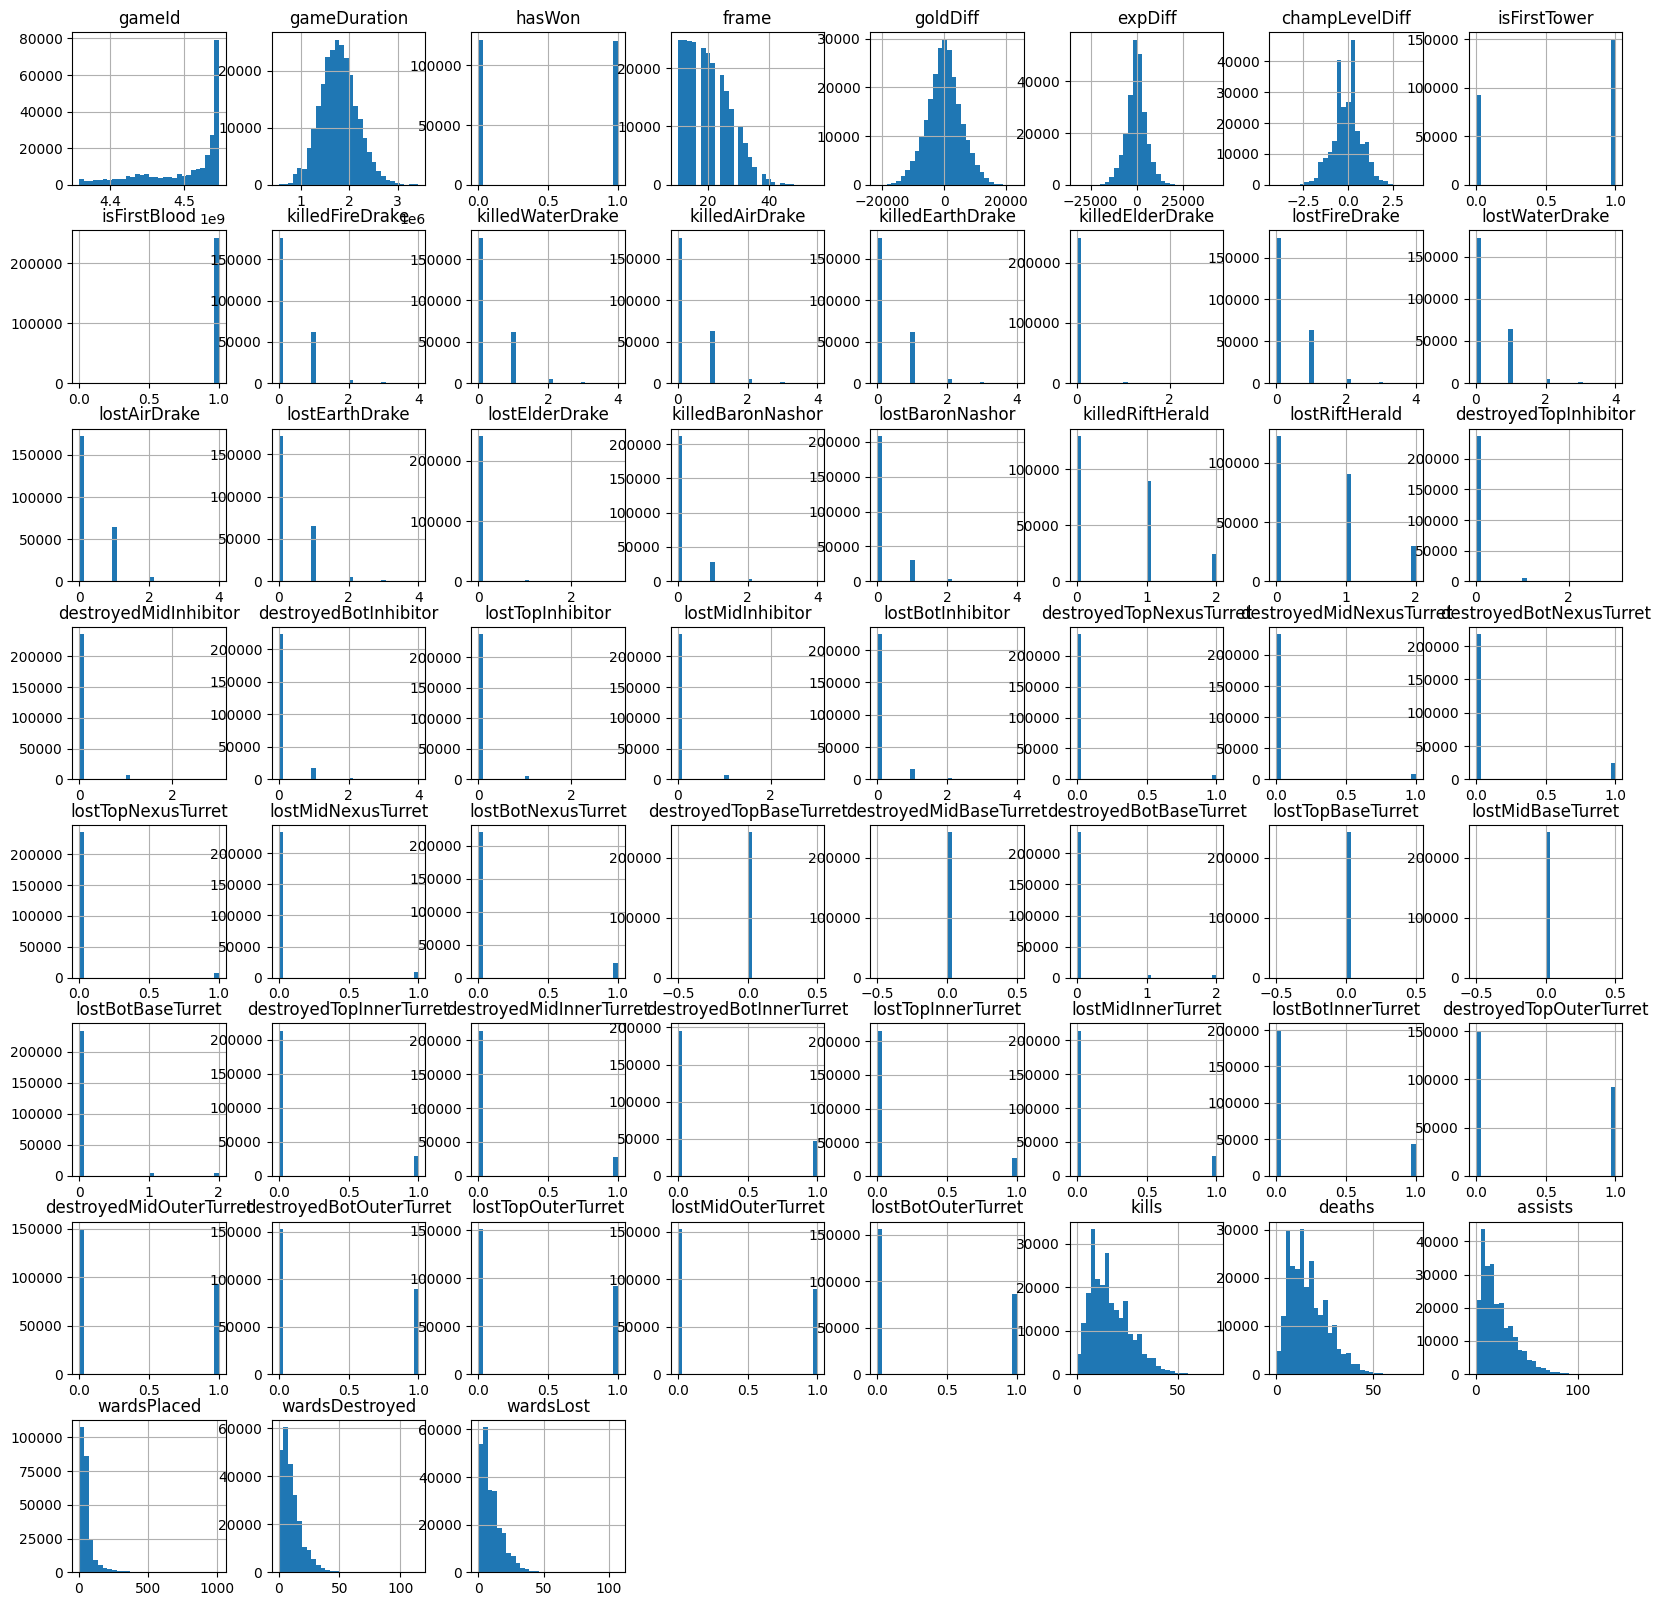

In [124]:
df.hist(bins=30, figsize=(20, 20))
plt.show()

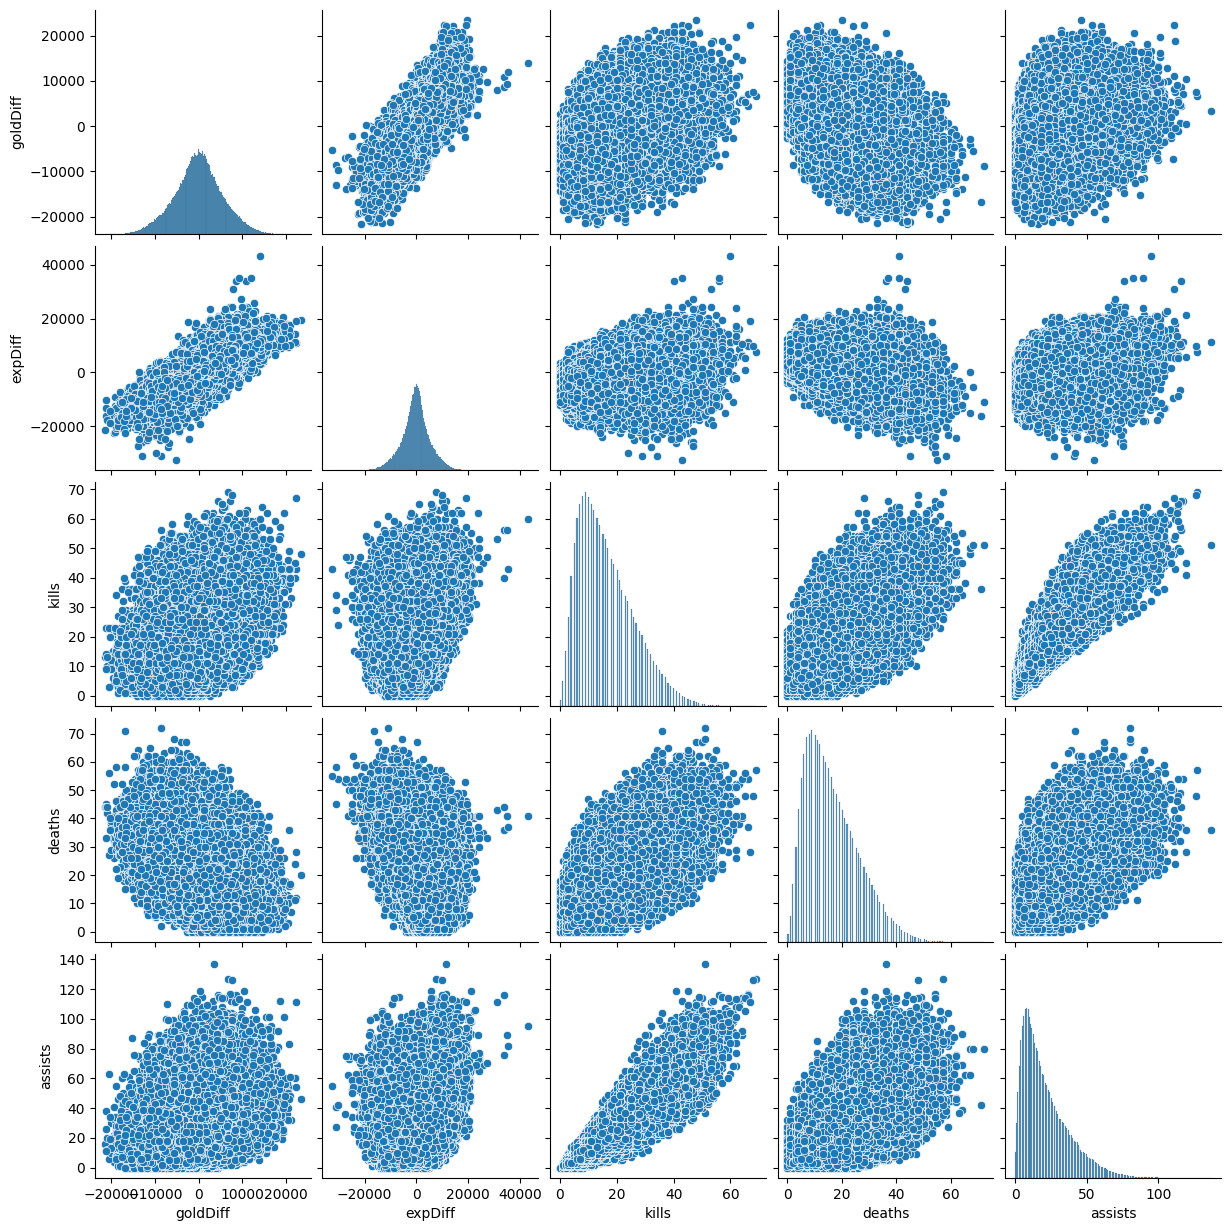

In [125]:
selected_columns = ['goldDiff', 'expDiff', 'kills', 'deaths', 'assists']
sns.pairplot(df[selected_columns])
plt.show()

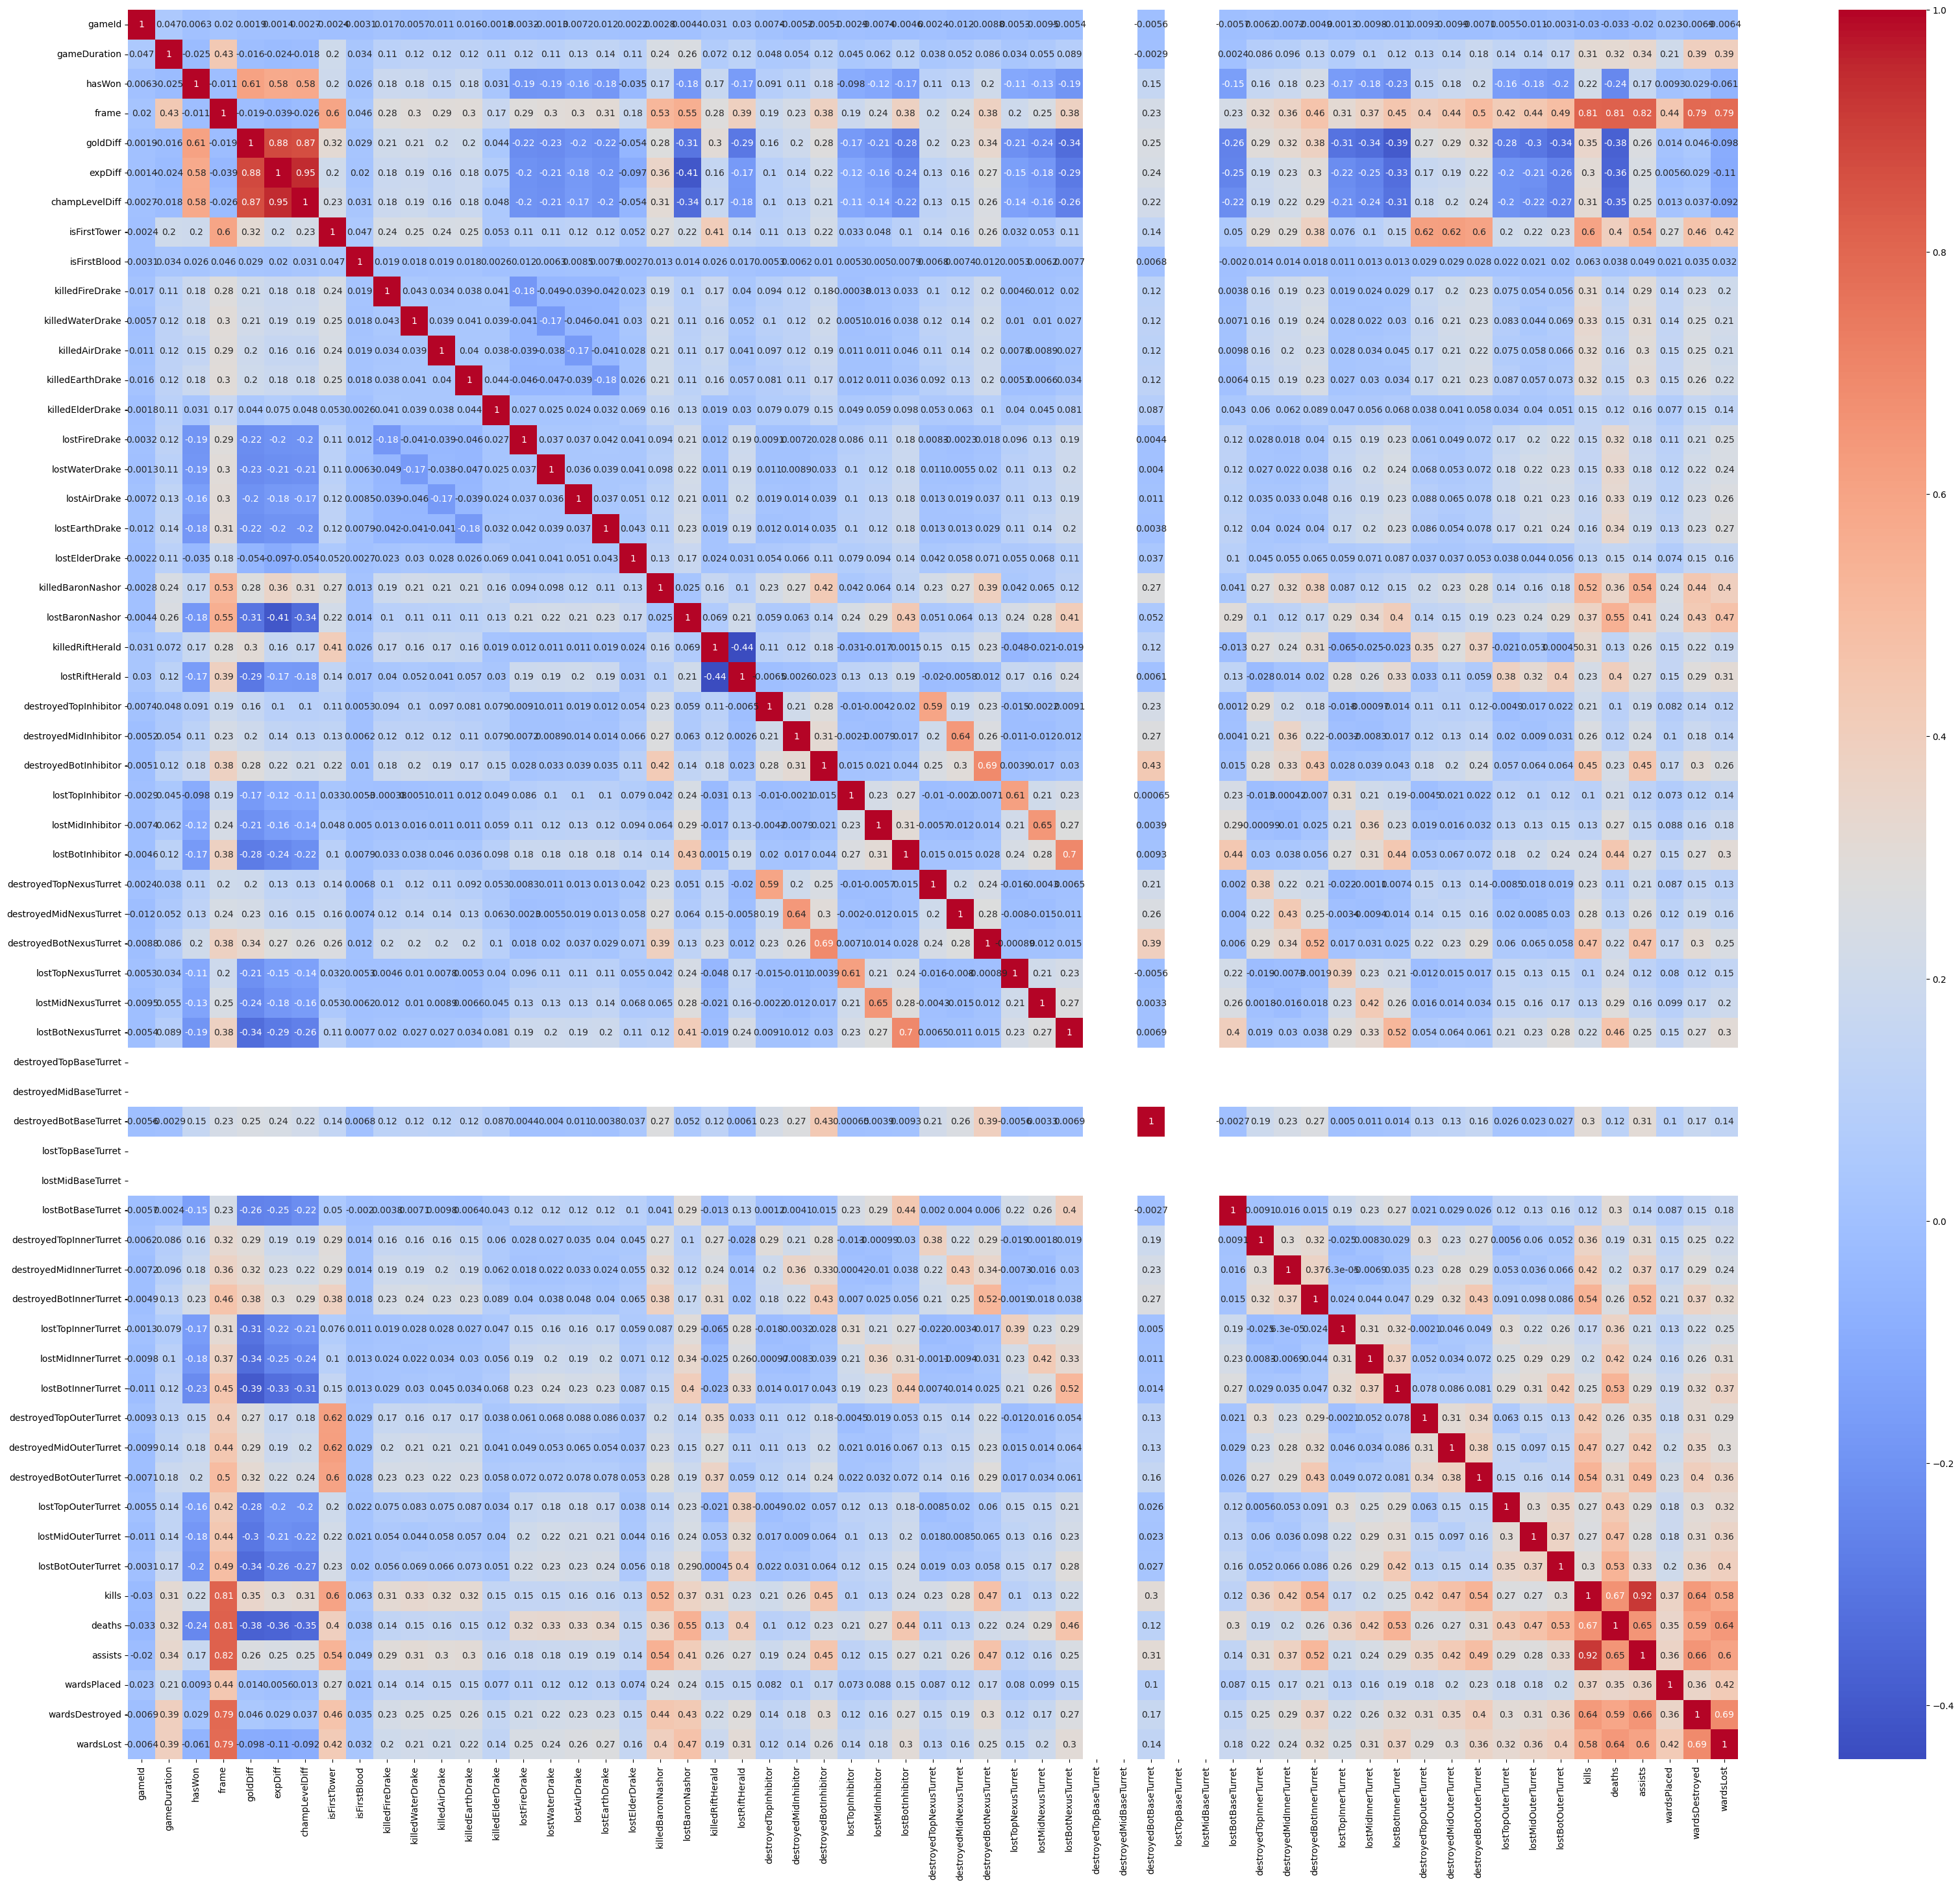

In [126]:
plt.figure(figsize=(40, 35))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

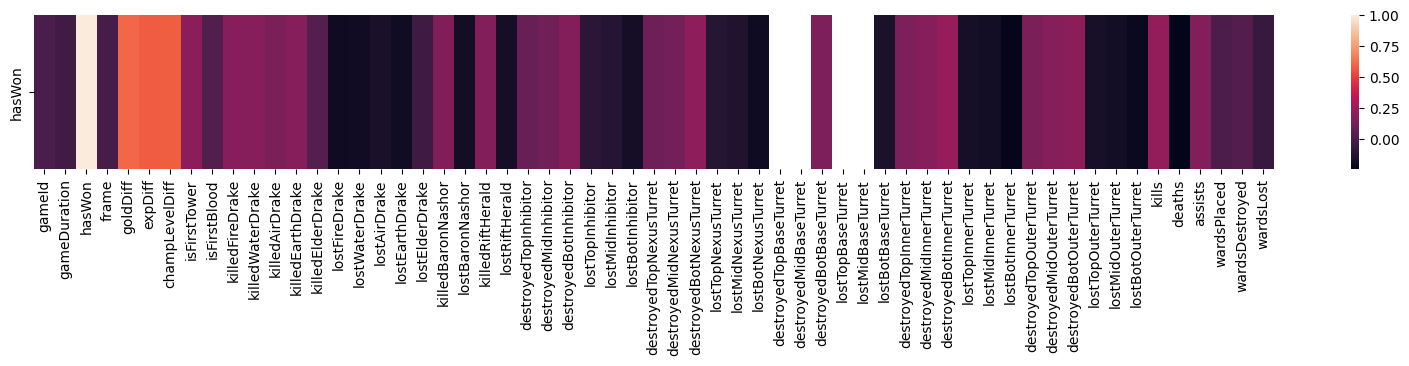

In [127]:
winning_correlation = df.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

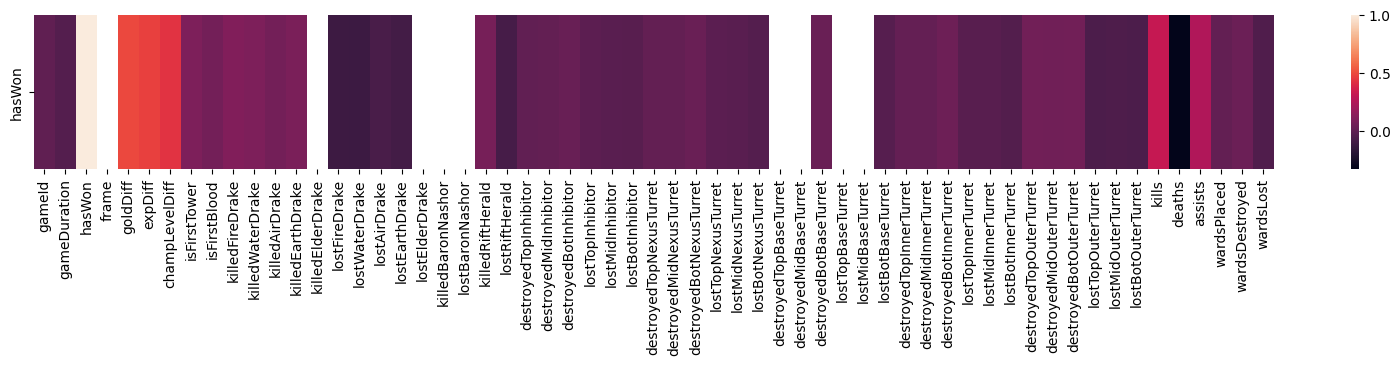

In [128]:
df_f10 = df[df['frame'] == 10]
winning_correlation = df_f10.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

In [129]:
high_impact_columns = ['goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood']
df_high_impact = df[high_impact_columns]
print(df_high_impact.tail(10))

        goldDiff  expDiff  champLevelDiff  kills  deaths  assists  \
242562      1440     1464             0.4     23      17       37   
242563      1291      634             0.2     25      20       41   
242564     -1321    -2549            -0.4     29      28       45   
242565     -4062    -5239            -0.8     30      32       47   
242566     -5640    -9016            -1.0     33      36       50   
242567     -8523   -13498            -1.6     33      41       50   
242568      -271    -1243            -0.2      6       5        6   
242569     -2013    -3493            -0.8      7       8        6   
242570     -2388    -4543            -0.8     10      13        9   
242571     -5601    -7595            -1.2     11      17       10   

        isFirstTower  isFirstBlood  
242562             1             1  
242563             1             1  
242564             1             1  
242565             1             1  
242566             1             1  
242567            

In [130]:
# from pgmpy.estimators import HillClimbSearch, BicScore
# from pgmpy.models import BayesianNetwork
# from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
# import networkx as nx

# # Filter for frame=10 and select high-impact columns
# df_high_impact = df[df['frame'] == 10][['goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood', 'hasWon']]

# # Learn structure using Hill Climb Search and BIC Score
# hc = HillClimbSearch(df_high_impact)
# model = hc.estimate(scoring_method=BicScore(df_high_impact))

# print("Bayesian Network Structure Edges:\n", model.edges())

# # Visualize the network
# plt.figure(figsize=(12, 8))
# G = nx.DiGraph(model.edges())
# nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=15, font_weight='bold')
# plt.title('Bayesian Network Structure')
# plt.show()

# # Estimate CPTs using Maximum Likelihood Estimator
# model = BayesianNetwork(model.edges())
# model.fit(df_high_impact, estimator=MaximumLikelihoodEstimator)

# # Display CPTs
# for node in model.nodes():
#     cpt = model.get_cpds(node)
#     print(f"\nCPT for {node}:\n", cpt)

# # Additional analysis to identify independent parameters
# independencies = model.get_independencies()
# print("\nIndependencies:\n", independencies)

In [131]:
# import pandas as pd
# from pgmpy.estimators import HillClimbSearch, BicScore
# from pgmpy.models import BayesianNetwork
# from pgmpy.estimators import MaximumLikelihoodEstimator
# import matplotlib.pyplot as plt
# import networkx as nx

# # Load CSV
# df = pd.read_csv('lol_ranked_games.csv')

# # Filter for frame=10 and select high-impact columns
# df_high_impact = df[df['frame'] == 10]#[['goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood', 'hasWon']]

# # Learn structure with hasWon as the final node
# hc = HillClimbSearch(df_high_impact)
# dag = hc.estimate(scoring_method=BicScore(df_high_impact), fixed_edges=[(col, 'hasWon') for col in df_high_impact.columns if col != 'hasWon'])

# # Convert DAG to Bayesian Network
# model = BayesianNetwork(dag.edges())

# # Visualize the network
# plt.figure(figsize=(12, 8))
# G = nx.DiGraph(dag.edges())
# nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=15, font_weight='bold')
# plt.title('Bayesian Network with hasWon as Final Output')
# plt.show()

# # Fit model and generate CPTs
# model.fit(df_high_impact, estimator=MaximumLikelihoodEstimator)
# for node in model.nodes():
#     cpt = model.get_cpds(node)
#     print(f"\nCPT for {node}:\n", cpt)


     hasWon  goldDiff  expDiff  kda  wardsDiff  isFirstBlood  isFirstTower  \
0         1         0        0    0          1             1             0   
8         1         1        1    1          1             1             0   
14        1         0        0    1          1             1             0   
25        0         1        1    1          1             1             0   
38        0         0        0    0          1             1             0   
45        1         1        1    1          1             1             0   
55        1         1        0    1          1             1             0   
68        0         0        0    0          1             1             0   
79        0         0        0    0          1             1             0   
89        0         0        0    0          1             1             0   
101       0         0        0    0          1             1             0   
106       1         1        1    1          1             1    

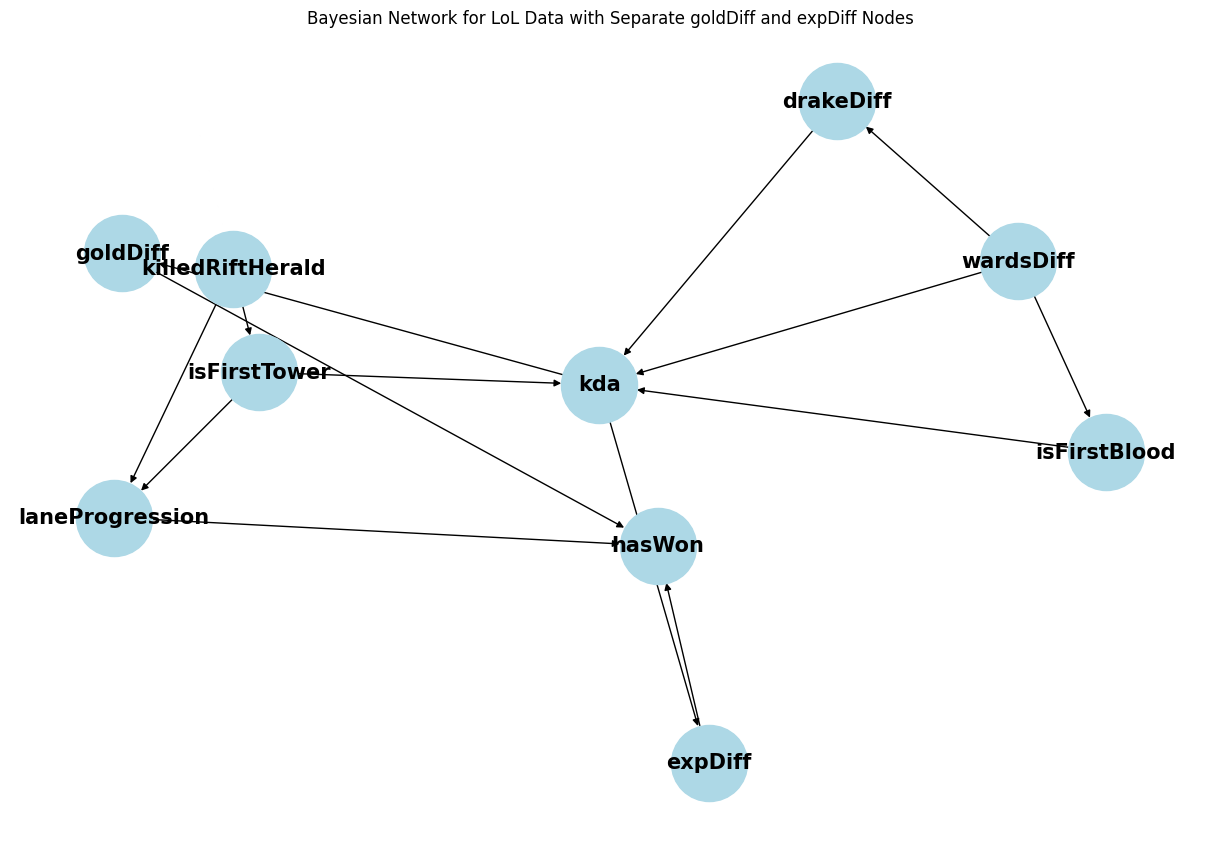

In [132]:
# Load CSV
df = pd.read_csv('lol_ranked_games.csv')

# Filter for frame=10
df_frame_10 = df[df['frame'] == 10].copy()

# Create derived columns
df_frame_10['kda'] = df_frame_10['kills'] + (df_frame_10['assists'] // 2) - df_frame_10['deaths']
drake_columns_killed = ['killedFireDrake', 'killedWaterDrake', 'killedAirDrake', 'killedEarthDrake']
drake_columns_lost = ['lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake']
df_frame_10['drakeDiff'] = df[drake_columns_killed].sum(axis=1) - df[drake_columns_lost].sum(axis=1)
df_frame_10['wardsDiff'] = df_frame_10['wardsPlaced'] - df_frame_10['wardsLost']

# Discretize data
df_frame_10['goldDiff'] = (df_frame_10['goldDiff'] > 0).astype(int)
df_frame_10['expDiff'] = (df_frame_10['expDiff'] > 0).astype(int)
df_frame_10['wardsDiff'] = (df_frame_10['wardsDiff'] > 0).astype(int)
df_frame_10['drakeDiff'] = (df_frame_10['drakeDiff'] > 0).astype(int)
df_frame_10['kda'] = (df_frame_10['kda'] > 1).astype(int)
df_frame_10['killedRiftHerald'] = (df_frame_10['killedRiftHerald'] > 0).astype(int)

# Select relevant columns
df_bn = df_frame_10[['hasWon', 'goldDiff', 'expDiff', 'kda', 'wardsDiff', 'isFirstBlood', 'isFirstTower',
                     'killedRiftHerald', 'drakeDiff']]
print(df_bn.head(20))

# Define Bayesian network edges manually based on provided design with separate goldDiff and expDiff
edges = [
    ('kda', 'goldDiff'),
    ('kda', 'expDiff'),
    ('isFirstBlood', 'kda'),
    ('drakeDiff', 'kda'),
    ('wardsDiff', 'drakeDiff'),
    ('wardsDiff', 'isFirstBlood'),
    ('wardsDiff', 'kda'),
    ('isFirstTower', 'laneProgression'),
    ('laneProgression', 'hasWon'),
    ('killedRiftHerald', 'laneProgression'),
    ('killedRiftHerald', 'isFirstTower'),
    ('drakeDiff', 'kda'),
    ('isFirstTower', 'kda'),
    ('goldDiff', 'hasWon'),
    ('expDiff', 'hasWon')
]

# Visualize the network
plt.figure(figsize=(12, 8))
G = nx.DiGraph(edges)
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=15, font_weight='bold')
plt.title('Bayesian Network for LoL Data with Separate goldDiff and expDiff Nodes')
plt.show()